In [13]:
import tensorflow as tf
import json
import os

from core.data  import load_records
from core.astromer import get_ASTROMER, get_FINETUNING, train

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('text', usetex=True)

plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
exp_path = './experiments/debug'

In [15]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 100,
 'data': './data/records/macho',
 'p': './experiments/debug',
 'batch_size': 256,
 'epochs': 2000,
 'patience': 200,
 'finetuning': False,
 'repeat': 10,
 'layers': 2,
 'heads': 4,
 'head_dim': 412,
 'dff': 1024,
 'dropout': 0.1,
 'max_len': 100,
 'base': 10000,
 'lr': 0.001}

In [16]:
test_batches = load_records(os.path.join(conf['data'], 'test'), 
                            conf['batch_size'], 
                            input_len=conf['max_obs'],
                            finetuning=conf['finetuning'])

In [17]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

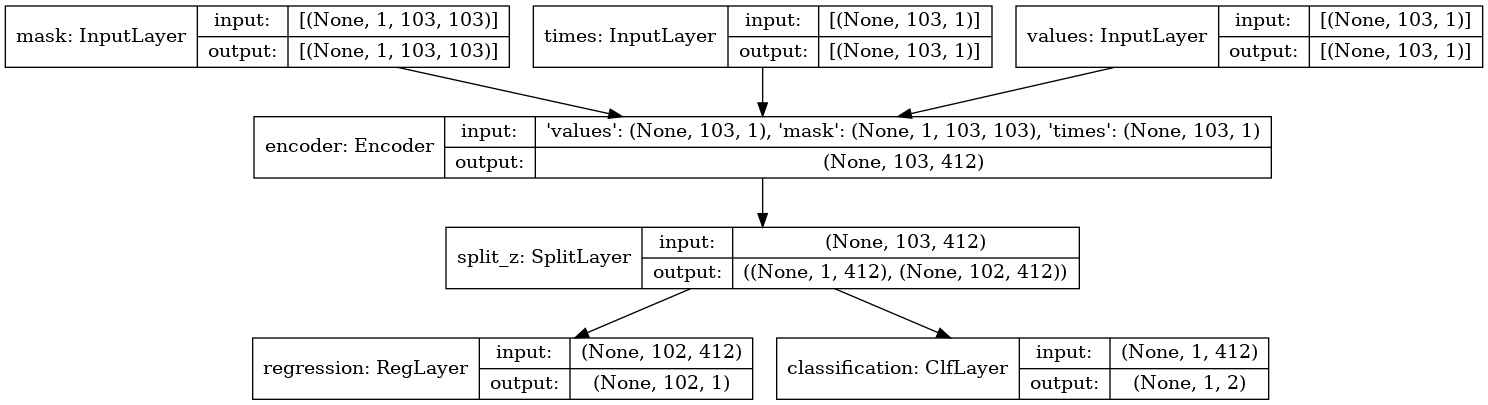

In [18]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [7]:
weights_path = '{}/weights'.format(conf['p'])
astromer.load_weights(weights_path)

In [8]:
from core.astromer import predict

In [10]:
result = predict(astromer, test_batches, conf, use_random=True)
result['acc']

prediction: 3it [00:04,  1.35s/it]


0.4723669

In [11]:
result['mse']

0.22076249

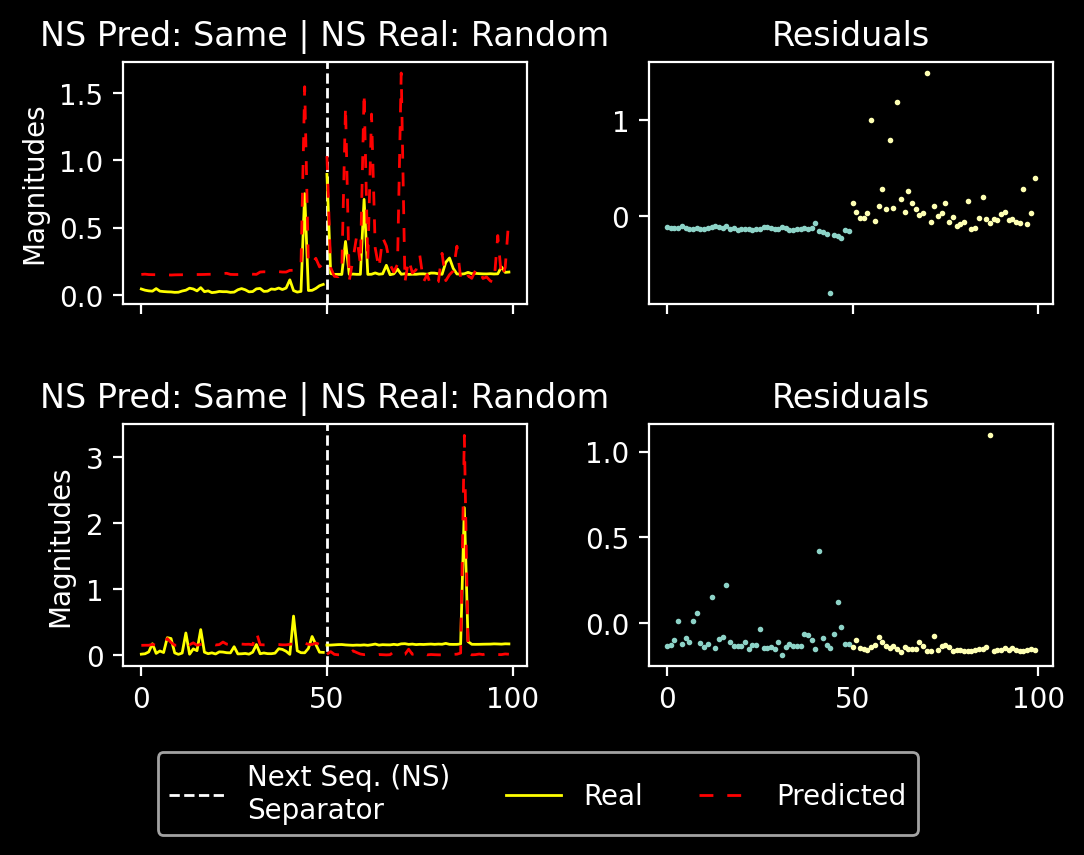

In [12]:
N = 2
fig, axes = plt.subplots(N, 2, dpi=200, 
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.3},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, obs*2)
    
    serie_1_pred = result['x_true'][i][:obs, 0]
    serie_1_true = result['x_pred'][i][:obs]
    residual_1 = serie_1_pred - tf.squeeze(serie_1_true)

    serie_2_pred = result['x_true'][i][obs+1:-1, 0]
    serie_2_true = result['x_pred'][i][obs+1:-1]
    residual_2 = serie_2_pred - tf.squeeze(serie_2_true)
    
    axes[i][0].axvline(x=obs, color='white', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='yellow')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))

    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='yellow', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2)
    axes[i][1].plot(times_post, residual_2, '.', markersize=2)
    axes[i][1].set_title('Residuals')
    
    
    npp_lab_pred = 'Random' if result['y_pred'][i] == 1 else 'Same'
    npp_lab_true = 'Random' if result['y_true'][i] == 1 else 'Same'
    axes[i][0].set_title(r"NS Pred: "+npp_lab_pred+" | "+r"NS Real: "+npp_lab_true)

    axes[i][0].set_ylabel('Magnitudes')
    
axes[1][0].legend(ncol=3, bbox_to_anchor = (2, -0.3))
# fig.tight_layout()

# Finetuning

In [12]:
finetuning_batches = load_records(os.path.join(conf['data'], 'test'), 
                                  conf['batch_size'], 
                                  input_len=conf['max_obs'],
                                  finetuning=True)

In [13]:
uniques, _ = tf.unique([b['label']for b in finetuning_batches.unbatch()])
num_cls = uniques.shape[0]

In [14]:
finetuning = get_FINETUNING(astromer, num_cls=num_cls)

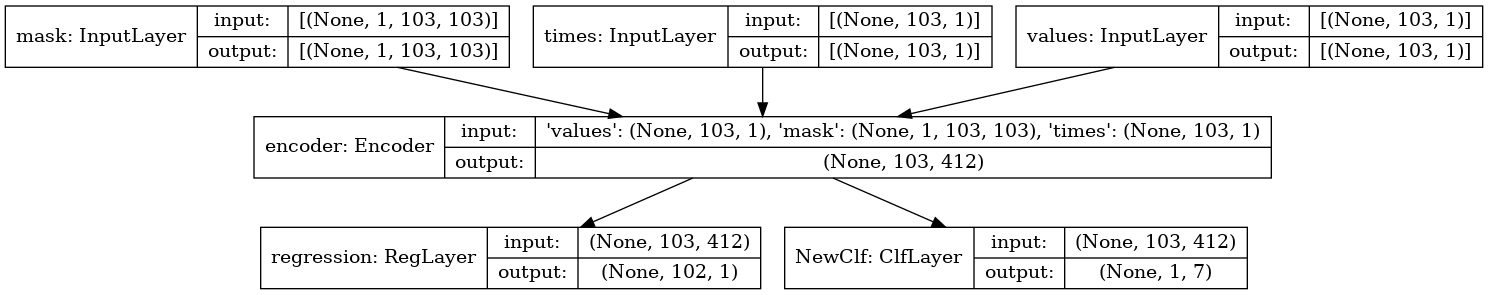

In [15]:
tf.keras.utils.plot_model(finetuning, show_shapes=True)

In [ ]:
train_batches = load_records(os.path.join(opt.data, 'train'),
                             opt.batch_size,
                             input_len=opt.max_obs,
                             repeat=opt.repeat,
                             balanced=True,
                             finetuning=opt.finetuning)
valid_batches = load_records(os.path.join(opt.data, 'val'),
                             opt.batch_size,
                             input_len=opt.max_obs,
                             repeat=opt.repeat,
                             balanced=True,
                             finetuning=opt.finetuning)

In [ ]:
train(finetuning,
      train_dataset,
      valid_dataset,
      patience=20,
      exp_path='./experiments/test',
      epochs=1,
      finetuning=False)

In [16]:
result = predict(finetuning, 
                 finetuning_batches, conf, 
                 predic_proba=True, 
                 use_random=False, 
                 finetuning=True)

prediction: 3it [00:02,  1.01it/s]
